In [1]:
import numpy as np
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [2]:
# Dataset transformation 
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
# Hyperparameters
batch_size = 32
N = 16
k = 3
num_filters = 64
epochs = 30
LR = 0.0005

# Reading datasets and creating dataloaders
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=6)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=6)

# Defining classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


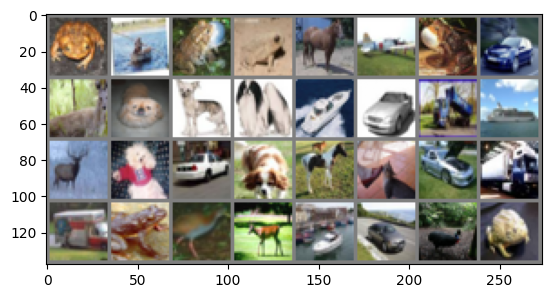

frog  ship  frog  frog  horse plane frog  car   deer  dog   dog   dog   ship  car   truck ship  deer  dog   car   dog   horse cat   car   truck truck frog  bird  deer  ship  car   bird  frog 


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
# print(images.shape)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

# Class BackbobeBlock defines the layers inside one block in the backbone
class BackboneBlock(nn.Module):
    def __init__(self, in_ch, out_ch, num_coefficients):
        super().__init__()
        self.in_channels = in_ch # The number of channels at the input of the block
        self.out_channels = out_ch # The number of channels at the output of the block
        self.k = num_coefficients # Defining k as per the assignment question representing k elements
        self.fc = nn.Linear(self.in_channels, self.k) # Linear layer to connect SpatialAveragePool to vector a.
        # Defining conv layer for convolutions 
        self.conv = nn.Sequential(
            nn.Conv2d(self.in_channels, self.out_channels, 3, padding= 'same'),
            nn.BatchNorm2d(self.out_channels))  


    def SpatialAveragePool(self, x):
        '''
        This method computes SpatialAveragePool as per the question in the assignment
        Input:
        x: Input tensor of size batch_size x d x w x h
        Returns: 
        Calculates the spatial average per channel returning a vector of d channels
        Tensor of size batch_size x d
        '''
        return torch.mean(torch.mean(x, 2),2)
    
    def forward(self, x):
        spatial_average = self.SpatialAveragePool(x) # Calculate SpatialAveragePool(X)
        a = F.softmax(self.fc(spatial_average), dim=-1) # a =  g(SpatialAveragePool(X)W) where g is softmax activation function 
        conv_outputs = [] # defining empty list to append output of convolutional layers of k convolutional operations
        # K convolutional layers
        for i in range(self.k):
            conv_outputs.append(self.conv(x))
        # Stacking all outputs from k convolutions
        conv_outputs_tensor = torch.stack(conv_outputs, 1)
        a_reshaped = a.reshape(-1,self.k,1,1,1)
        # K conv layers which are combined using a to produce a single output: O = a1 * Conv1(X) + ...+ aK * ConvK(X)
        block_output = torch.sum(torch.mul(a_reshaped, conv_outputs_tensor), 1)
        return block_output

# Class to create the model 
class Net(nn.Module):
    def __init__(self, num_blocks, num_coefficients, num_channels):
        super().__init__()
        self.N = num_blocks # Number of blocks in the backbone
        self.k = num_coefficients # Size of vector a
        self.out_channels = num_channels # Output channels of the output of blocks
        self.block1 = BackboneBlock(3, self.out_channels, self.k)
        self.block2 = BackboneBlock(self.out_channels, self.out_channels, self.k)
        self.fc1 = nn.Linear(self.out_channels, 32) # Classifier layers 
        self.fc2 = nn.Linear(32, 10)
    
    def SpatialAveragePool(self, x):
        '''
        This method computes SpatialAveragePool as per the question in the assignment
        Input:
        x: Input tensor of size: (batch_size, d, w, h)
        Returns: 
        Calculates the spatial average per channel returning a vector of d channels
        Tensor of size: (batch_size, d)
        '''
        return torch.mean(torch.mean(x, 2),2)
        
    def forward(self, x):
        x = F.relu(self.block1(x))
        
        for i in range(self.N - 2):
            xb = self.block2(x)
            x = F.relu(xb + x)
        
        x = F.relu(self.block2(x))
        
        x = self.SpatialAveragePool(x)
        # Classifier
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x



net = Net(N, k, num_filters)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [7]:
net = net.to(device)

In [8]:
net

Net(
  (block1): BackboneBlock(
    (fc): Linear(in_features=3, out_features=3, bias=True)
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (block2): BackboneBlock(
    (fc): Linear(in_features=64, out_features=3, bias=True)
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.0001, momentum=0.9, weight_decay= 1e-4)
optimizer = optim.Adam(net.parameters(), lr=LR) 

In [10]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    step_losses_train = []
    step_losses_test = []
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        # print statistics is mini-batches are more than 2000
        step_losses_train.append(loss.item())
        running_loss += step_losses_train[-1]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
        
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
    
    for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # print statistics
        step_losses_test.append(loss.item())
        _, predicted = torch.max(outputs, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        
    train_loss.append(np.mean(np.array(step_losses_train)))
    test_loss.append(np.mean(np.array(step_losses_test)))
    train_accuracy.append(100 * float(train_correct) / train_total)
    test_accuracy.append(100 * float(test_correct) / test_total)
    print(f'epoch: {epoch + 1} train loss: {train_loss[-1]} test loss:{test_loss[-1]} train accuracy: {train_accuracy[-1]} test accuracy:{test_accuracy[-1]}')
print('Finished Training')

epoch: 1 train loss: 1.6100632170416649 test loss:1.3847462392081848 train accuracy: 39.842 test accuracy:48.68
epoch: 2 train loss: 1.2987900344286678 test loss:1.2176860509969938 train accuracy: 52.318 test accuracy:55.7
epoch: 3 train loss: 1.1582656490520569 test loss:1.1287232309865494 train accuracy: 57.796 test accuracy:58.87
epoch: 4 train loss: 1.0701207386249925 test loss:1.0407554293973758 train accuracy: 61.248 test accuracy:62.23
epoch: 5 train loss: 1.0099444516332043 test loss:0.9862617189510943 train accuracy: 63.72 test accuracy:64.71
epoch: 6 train loss: 0.9596641737912911 test loss:0.9693474007871585 train accuracy: 65.516 test accuracy:65.25
epoch: 7 train loss: 0.9235918294788551 test loss:0.9215669549120882 train accuracy: 66.918 test accuracy:66.73
epoch: 8 train loss: 0.8909008848842564 test loss:0.8918024164419205 train accuracy: 67.968 test accuracy:67.94
epoch: 9 train loss: 0.8611305448883859 test loss:0.8720350800611721 train accuracy: 69.066 test accuracy:

In [11]:
# Save model 
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

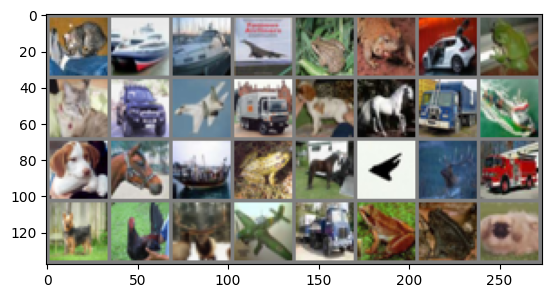

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car   plane truck dog   horse truck ship  dog   horse ship  frog  horse plane deer  truck dog   bird  deer  plane truck frog  frog  dog  


In [12]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [13]:
# Load Model
net = Net(N, k, num_filters)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [14]:
outputs = net(images)

In [15]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(batch_size)))

Predicted:  cat   plane ship  plane bird  cat   car   deer  cat   plane plane truck dog   horse truck frog  dog   horse ship  frog  horse plane ship  truck deer  cat   bird  plane truck deer  frog  dog  


In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total:.1f} %')

Accuracy of the network on the 10000 test images: 76.8 %


In [17]:
import matplotlib.pyplot as plt

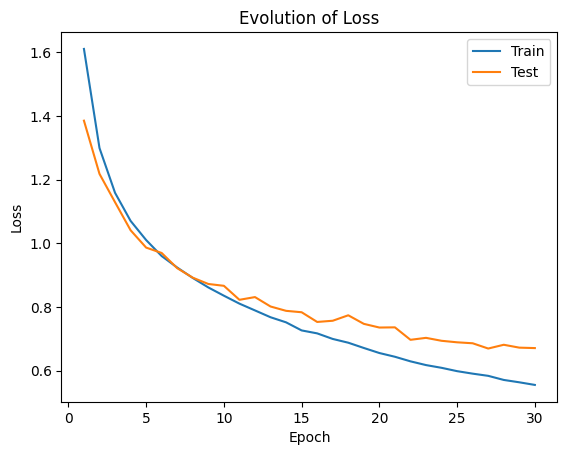

In [18]:
# Plotting evolution of Loss
plt.plot(np.arange(1, epochs + 1 , 1),train_loss, label = 'Train')
plt.plot(np.arange(1, epochs + 1 , 1),test_loss, label = 'Test')
plt.title('Evolution of Loss')
plt.legend(loc="upper right")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

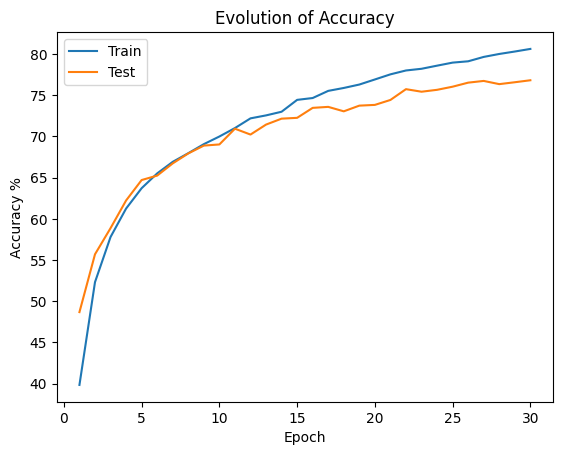

In [19]:
# Plotting evolution of Accuracy %
plt.plot(np.arange(1, epochs + 1, 1),train_accuracy, label = 'Train')
plt.plot(np.arange(1, epochs + 1, 1),test_accuracy, label = 'Test')
plt.title('Evolution of Accuracy')
plt.legend(loc="upper left")
plt.xlabel('Epoch')
plt.ylabel('Accuracy %')
plt.show()

In [20]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 81.7 %
Accuracy for class: car   is 84.0 %
Accuracy for class: bird  is 71.6 %
Accuracy for class: cat   is 65.1 %
Accuracy for class: deer  is 72.0 %
Accuracy for class: dog   is 68.5 %
Accuracy for class: frog  is 74.6 %
Accuracy for class: horse is 78.8 %
Accuracy for class: ship  is 85.9 %
Accuracy for class: truck is 86.0 %
